In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
import numpy as np
import optuna
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


data= pd.read_csv('1dataset.csv')

In [ ]:
# 1. Реализация MAE
def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# 2. Реализация MSE
def custom_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# 3. Реализация RMSE
def custom_rmse(y_true, y_pred):
    return np.sqrt(custom_mse(y_true, y_pred))

# 4. Реализация R²
def custom_r2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_res / ss_total)

# 5. Реализация MAPE
def custom_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Создадим таблицу для вывода
А также функцию, добавляющую метрики в датафрейм

In [42]:
table_all_metrics = pd.DataFrame(columns=['Model','MAE','MSE','RMSE','MAPE','R^2','Custom_MAE,','Custom_MSE','Custom_RMSE','Custom_MAPE','Custom_R^2'])

In [43]:
def add_err_to_dataframe(dataframe, model_name, dict_errors):
    new_row = {'Model': model_name}
    
    # Добавляем ошибки в строку
    for error, value in dict_errors.items():
        new_row[error] = value
    
    # Добавляем строку в DataFrame .loc[] используется для доступа к строкам по метке.
    # Таким образом, она указывает на новую позицию после последней строки.
    
    dataframe.loc[len(dataframe)] = new_row

# Линейная регрессия

In [44]:
# Разделение на признаки и целевую переменную
y = data["price"]
X = data.drop(["price"], axis=1)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
lr = LinearRegression().fit(X_train, y_train)

# Предсказание
y_pred = lr.predict(X_test)


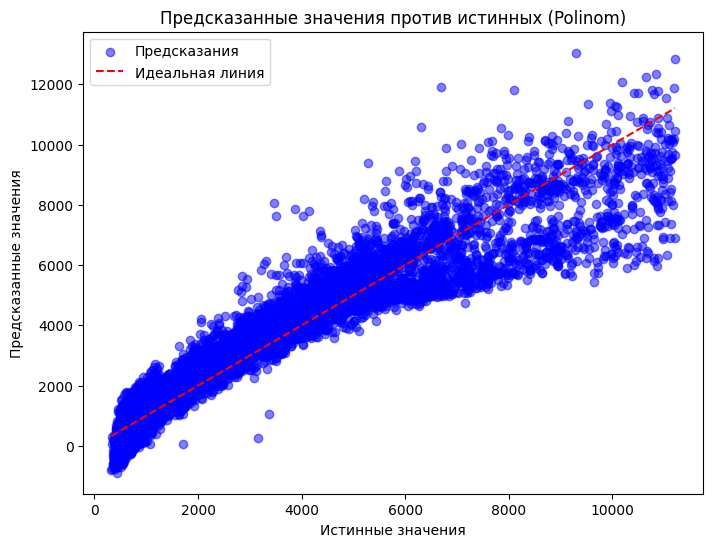

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

Напишем функции, которые добавят метрики в таблицу

In [46]:
def dict_errors(y_pred, y_test):
  return {'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': sqrt(mean_squared_error(y_test, y_pred)),
          'MAPE': sqrt(mean_absolute_percentage_error(y_test, y_pred)),
          'R^2': r2_score(y_test, y_pred),
          'Custom_MAE' : custom_mae(y_test, y_pred),
          'Custom_MSE' : custom_mse(y_test,y_pred),
          'Custom_RMSE' : custom_rmse(y_test, y_pred),
          'Custom_MAPE' : custom_mape(y_test, y_pred),
          'custom_r2' : custom_r2(y_test, y_pred)}

In [47]:
this_dict_errors = dict_errors(y_pred, y_test)
add_err_to_dataframe(table_all_metrics, 'Linear_regression', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 561.4397703105604
MSE: 670719.300001884
RMSE: 818.9745417300126
MAPE: 0.5517882062444024
R^2: 0.903072854355253
Custom_MAE: 561.4397703105604
Custom_MSE: 670719.300001884
Custom_RMSE: 818.9745417300126
Custom_MAPE: 30.447022455041513
custom_r2: 0.903072854355253


In [48]:
print(lr.coef_)
print(lr.intercept_)

[ 1.27688561e+04  4.80733778e+01  1.35940577e+02  3.38770849e+02
  4.21937809e+03  6.12573590e+01 -4.63392395e+03  6.57981003e+04
 -7.79955510e+04  8.55841125e+05]
-2450.8377377352276


# L1 регрессия, она же Лассо

In [49]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(Lasso(), alpha_values).fit(X_train, y_train)
y_pred_lasso_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_grid', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 568.9363566658985
MSE: 683407.2728115125
RMSE: 826.6845062123231
MAPE: 0.5594405459520482
R^2: 0.9012392870366265
Custom_MAE: 568.9363566658985
Custom_MSE: 683407.2728115125
Custom_RMSE: 826.6845062123231
Custom_MAPE: 31.29737244551258
custom_r2: 0.9012392870366265


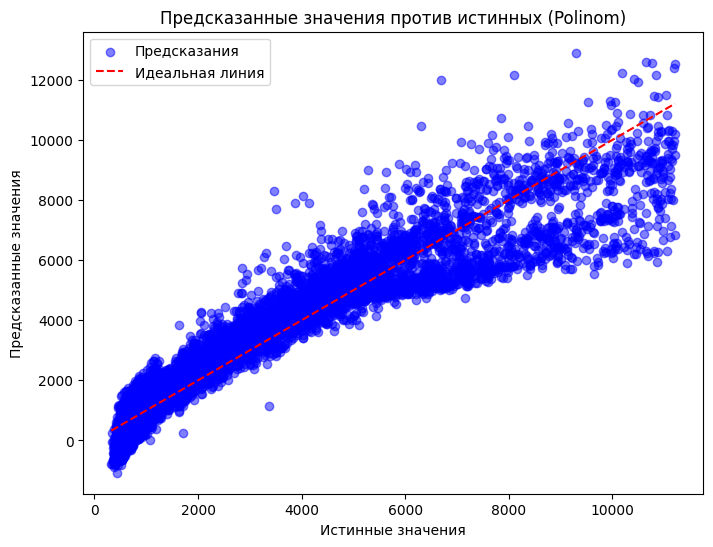

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [51]:
random_search = RandomizedSearchCV(
        Lasso(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости одинаковых результатов
    ).fit(X_train, y_train)
y_pred_lasso_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_random', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 568.9363566658985
MSE: 683407.2728115125
RMSE: 826.6845062123231
MAPE: 0.5594405459520482
R^2: 0.9012392870366265
Custom_MAE: 568.9363566658985
Custom_MSE: 683407.2728115125
Custom_RMSE: 826.6845062123231
Custom_MAPE: 31.29737244551258
custom_r2: 0.9012392870366265


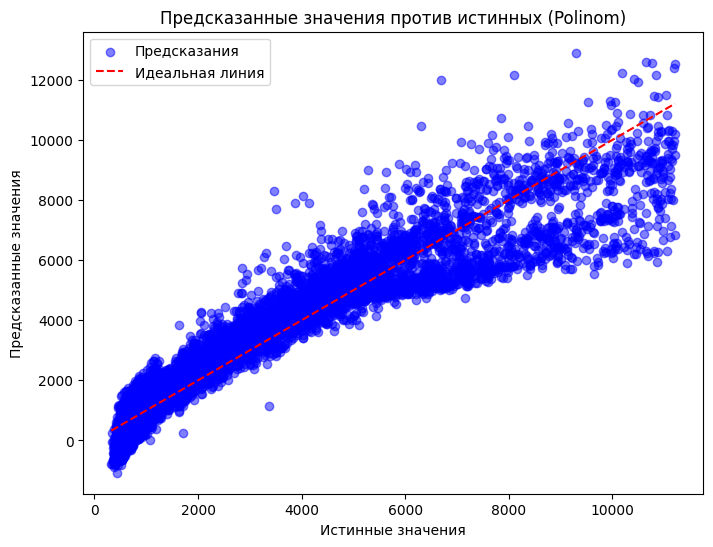

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [53]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_lasso(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    lasso = Lasso(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [54]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_lasso, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
lasso = Lasso(**best_params)
lasso.fit(X_train, y_train)
y_pred_lasso_optuna = lasso.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_optuna', this_dict_errors)


[I 2025-04-08 08:55:56,476] A new study created in memory with name: no-name-94af53aa-0d7b-48df-b0ed-e969399fbfbf
[I 2025-04-08 08:55:57,079] Trial 0 finished with value: -689787.3912480712 and parameters: {'alpha': 0.44229294422631477}. Best is trial 0 with value: -689787.3912480712.
C:\Users\Иван\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.267e+08, tolerance: 2.083e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\Иван\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the n

In [55]:
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 561.7556145790776
MSE: 671508.0482548759
RMSE: 819.4559465004058
MAPE: 0.5526211029114431
R^2: 0.9029588705817212
Custom_MAE: 561.7556145790776
Custom_MSE: 671508.0482548759
Custom_RMSE: 819.4559465004058
Custom_MAPE: 30.53900833830598
custom_r2: 0.9029588705817212


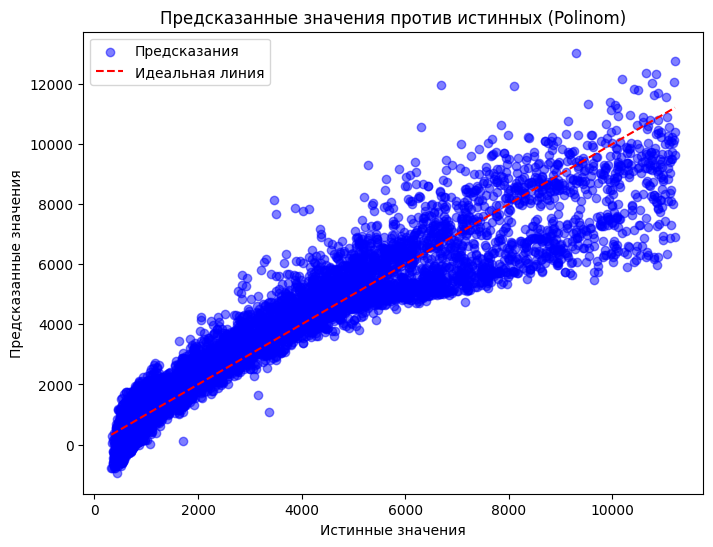

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# L2 (Ridge)

In [57]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(Ridge(), alpha_values).fit(X_train, y_train)
y_pred_ridge_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Ridge_grid', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 567.8878532575194
MSE: 682353.1254677525
RMSE: 826.0466847992021
MAPE: 0.5584346056224383
R^2: 0.9013916242261473
Custom_MAE: 567.8878532575194
Custom_MSE: 682353.1254677525
Custom_RMSE: 826.0466847992021
Custom_MAPE: 31.18492087566882
custom_r2: 0.9013916242261473


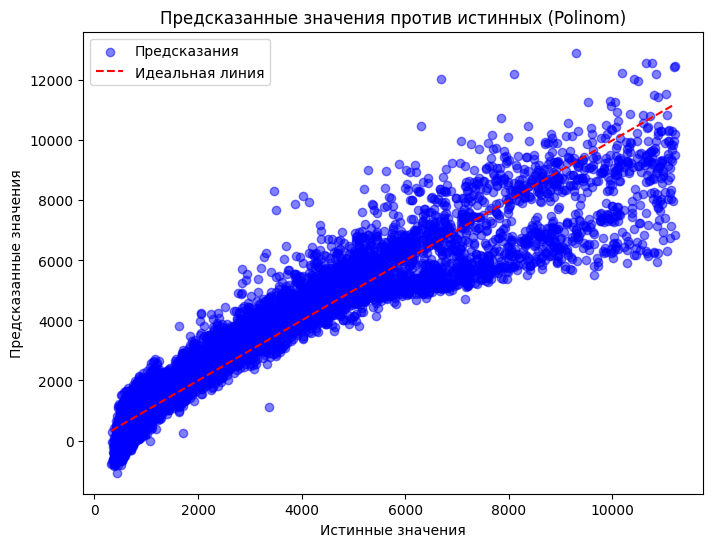

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [59]:
random_search = RandomizedSearchCV(
        Ridge(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости одинаковых результатов
    ).fit(X_train, y_train)
y_pred_ridge_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Ridge_random', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 567.8878532575194
MSE: 682353.1254677525
RMSE: 826.0466847992021
MAPE: 0.5584346056224383
R^2: 0.9013916242261473
Custom_MAE: 567.8878532575194
Custom_MSE: 682353.1254677525
Custom_RMSE: 826.0466847992021
Custom_MAPE: 31.18492087566882
custom_r2: 0.9013916242261473


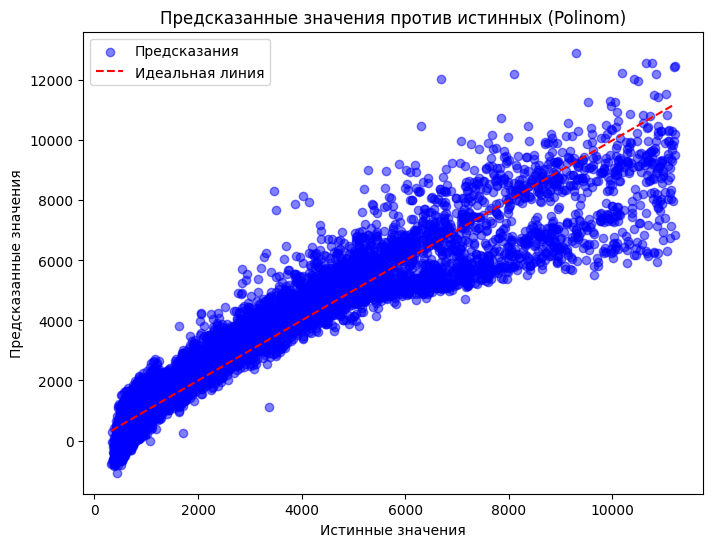

In [60]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [61]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_ridge(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    ridge = Ridge(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [62]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_ridge, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
ridge = Ridge(**best_params)
ridge.fit(X_train, y_train)
y_pred_ridge_optuna = ridge.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'ridge_optuna', this_dict_errors)


[I 2025-04-08 08:56:48,325] A new study created in memory with name: no-name-8e6d6841-94c4-4f36-9ff7-f6be6ad3baf7
[I 2025-04-08 08:56:48,376] Trial 0 finished with value: -680580.618198477 and parameters: {'alpha': 0.005300353308241983}. Best is trial 0 with value: -680580.618198477.
[I 2025-04-08 08:56:48,432] Trial 1 finished with value: -797201.9536704014 and parameters: {'alpha': 18.421387324725586}. Best is trial 0 with value: -680580.618198477.
[I 2025-04-08 08:56:48,492] Trial 2 finished with value: -764072.3590838604 and parameters: {'alpha': 8.774642760233734}. Best is trial 0 with value: -680580.618198477.
[I 2025-04-08 08:56:48,553] Trial 3 finished with value: -683232.8612037558 and parameters: {'alpha': 0.11255426206450694}. Best is trial 0 with value: -680580.618198477.
[I 2025-04-08 08:56:48,625] Trial 4 finished with value: -813766.5620256937 and parameters: {'alpha': 24.49439242767383}. Best is trial 0 with value: -680580.618198477.
[I 2025-04-08 08:56:48,695] Trial 5 

In [63]:
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 564.5466999770698
MSE: 675723.6430688614
RMSE: 822.0241134351604
MAPE: 0.5555374437385399
R^2: 0.9023496655498796
Custom_MAE: 564.5466999770698
Custom_MSE: 675723.6430688614
Custom_RMSE: 822.0241134351604
Custom_MAPE: 30.862185139555137
custom_r2: 0.9023496655498796


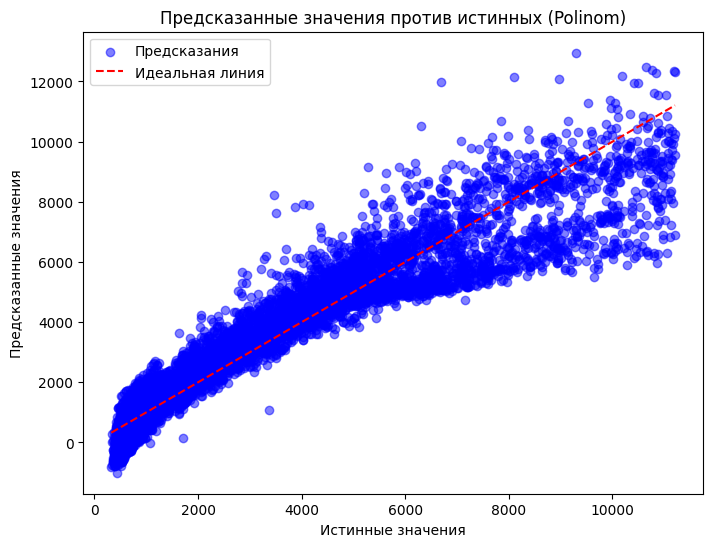

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Elastic Net (линейная регрессия с двумя регуляризаторами)

Lasso может случайно отбросить важные, а Ridge не делает отбор. ElasticNet — компромисс.

In [65]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(ElasticNet(), alpha_values).fit(X_train, y_train)
y_pred_elastic_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_grid', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 1676.9683382163487
MSE: 4635601.555117357
RMSE: 2153.0447173984467
MAPE: 1.0584936852950062
R^2: 0.33009885494183056
Custom_MAE: 1676.9683382163487
Custom_MSE: 4635601.555117357
Custom_RMSE: 2153.0447173984467
Custom_MAPE: 112.04088818094036
custom_r2: 0.33009885494183056


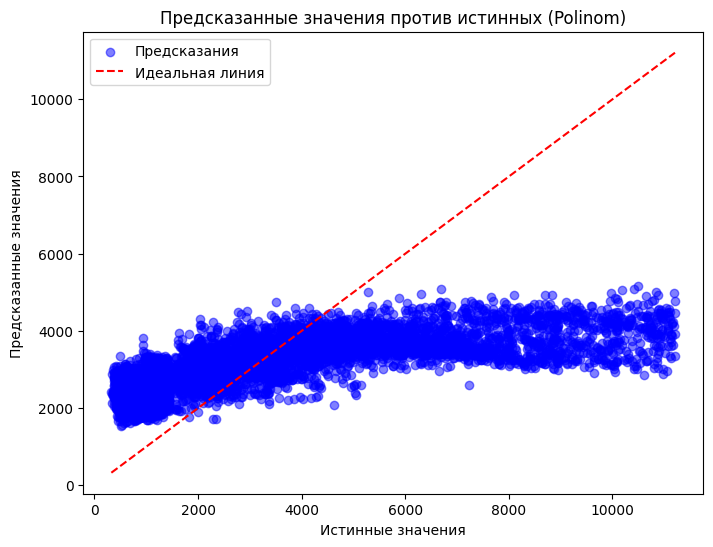

In [66]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [67]:
random_search = RandomizedSearchCV(
        ElasticNet(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости одинаковых результатов
    ).fit(X_train, y_train)
y_pred_elastic_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_random', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 1676.9683382163487
MSE: 4635601.555117357
RMSE: 2153.0447173984467
MAPE: 1.0584936852950062
R^2: 0.33009885494183056
Custom_MAE: 1676.9683382163487
Custom_MSE: 4635601.555117357
Custom_RMSE: 2153.0447173984467
Custom_MAPE: 112.04088818094036
custom_r2: 0.33009885494183056


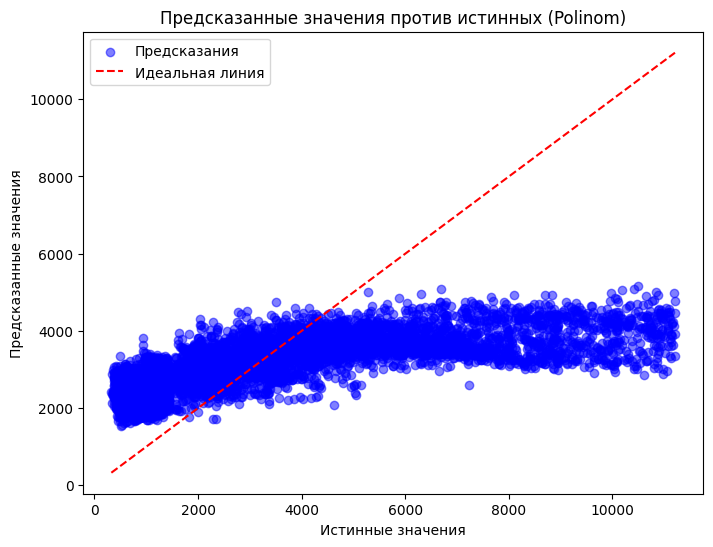

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [69]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_elastic(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    elastic = ElasticNet(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(elastic, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [70]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_elastic, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
elastic = Ridge(**best_params)
elastic.fit(X_train, y_train)
y_pred_elastic_optuna = elastic.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_optuna', this_dict_errors)


[I 2025-04-08 08:56:55,549] A new study created in memory with name: no-name-4e43f0c2-7479-4901-b72c-d8b078eacc23
[I 2025-04-08 08:56:55,846] Trial 0 finished with value: -1238085.150977673 and parameters: {'alpha': 0.008837942179626515}. Best is trial 0 with value: -1238085.150977673.
[I 2025-04-08 08:56:56,482] Trial 1 finished with value: -5989772.190442426 and parameters: {'alpha': 0.3451912374914675}. Best is trial 0 with value: -1238085.150977673.
[I 2025-04-08 08:56:56,706] Trial 2 finished with value: -1010420.4345689655 and parameters: {'alpha': 0.005472885307977794}. Best is trial 2 with value: -1010420.4345689655.
[I 2025-04-08 08:56:56,790] Trial 3 finished with value: -4635862.343612297 and parameters: {'alpha': 0.09825088713325691}. Best is trial 2 with value: -1010420.4345689655.
[I 2025-04-08 08:56:56,985] Trial 4 finished with value: -4294771.13505036 and parameters: {'alpha': 0.07901639699808348}. Best is trial 2 with value: -1010420.4345689655.
[I 2025-04-08 08:56:57

In [71]:
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 564.495129555884
MSE: 675618.0915193913
RMSE: 821.9599087056444
MAPE: 0.5554898126133176
R^2: 0.9023649190402868
Custom_MAE: 564.495129555884
Custom_MSE: 675618.0915193913
Custom_RMSE: 821.9599087056444
Custom_MAPE: 30.856893191717873
custom_r2: 0.9023649190402868


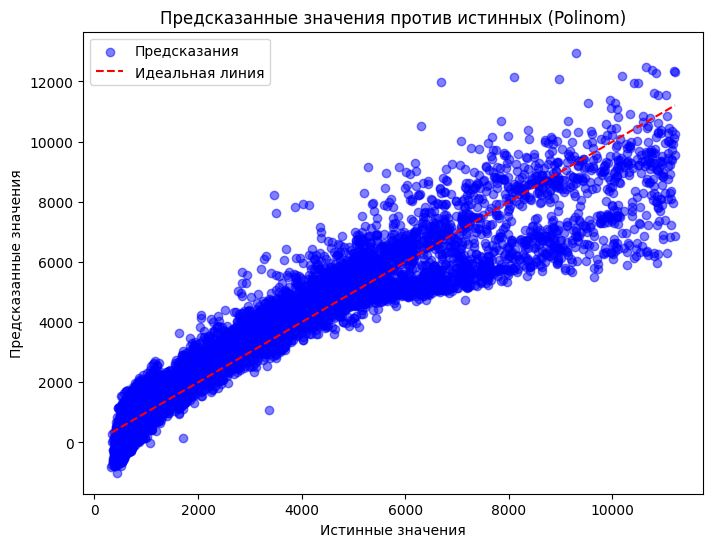

In [72]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Полиномиальная

Это расширение линейной регрессии, которое позволяет моделировать нелинейные зависимости между признаками и целевой переменной за счет добавления полиномиальных членов.

In [73]:
poly = PolynomialFeatures(degree=2)  # degree=2 означает квадратичные признаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучение модели
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Предсказания на тестовой выборке
y_pred_poly = poly_model.predict(X_test_poly)

this_dict_errors = dict_errors(y_pred_poly, y_test)
add_err_to_dataframe(table_all_metrics, 'Polinom', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 390.77953933650906
MSE: 374104.14330854395
RMSE: 611.6405343897214
MAPE: 0.4098228441955504
R^2: 0.9459373738243871
Custom_MAE: 390.77953933650906
Custom_MSE: 374104.14330854395
Custom_RMSE: 611.6405343897214
Custom_MAPE: 16.795476362453037
custom_r2: 0.9459373738243871


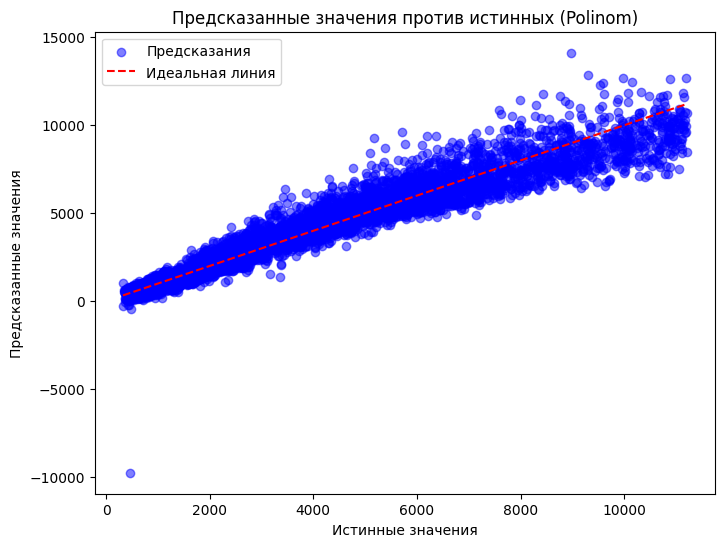

In [74]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Пайплайн

Это инструмент для объединения нескольких этапов обработки данных и моделирования в единый объект. Он помогает:

Упростить код, избежать утечек данных, упростить подбор гиперпараметров,

In [75]:
# Создание пайплайна
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),  # Полиномиальные признаки степени 2
    ('linear_regression', LinearRegression())                            # Линейная регрессия
])

# Обучение пайплайна
pipeline.fit(X_train, y_train)

# Предсказание и оценка
y_pred_pipeline = pipeline.predict(X_test)

this_dict_errors = dict_errors(y_pred_pipeline, y_test)
add_err_to_dataframe(table_all_metrics, 'Pipeline', this_dict_errors)
formatted_output = "\n".join([f"{key}: {value}" for key, value in this_dict_errors.items()])
print(formatted_output)

MAE: 390.77953933650906
MSE: 374104.14330854395
RMSE: 611.6405343897214
MAPE: 0.4098228441955504
R^2: 0.9459373738243871
Custom_MAE: 390.77953933650906
Custom_MSE: 374104.14330854395
Custom_RMSE: 611.6405343897214
Custom_MAPE: 16.795476362453037
custom_r2: 0.9459373738243871


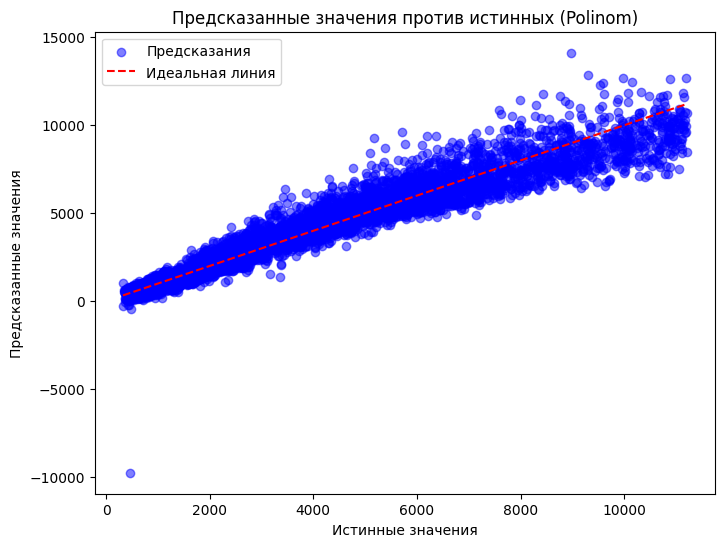

In [76]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_pipeline, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

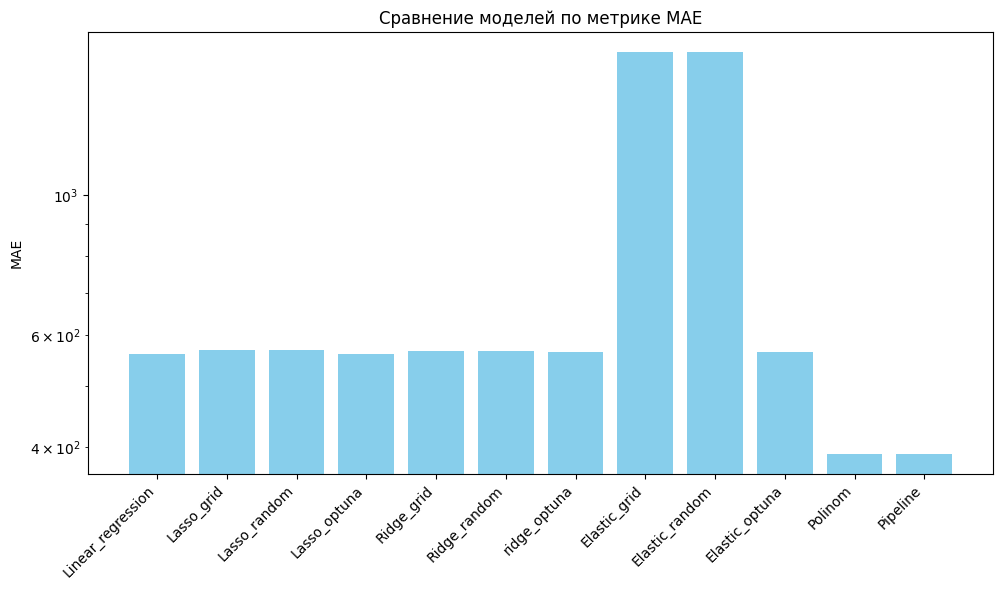

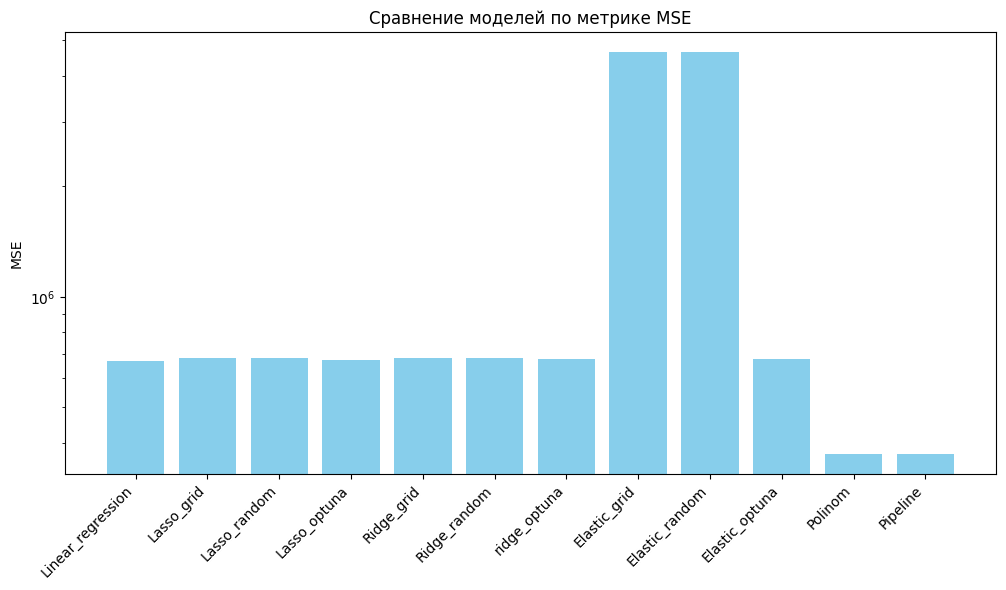

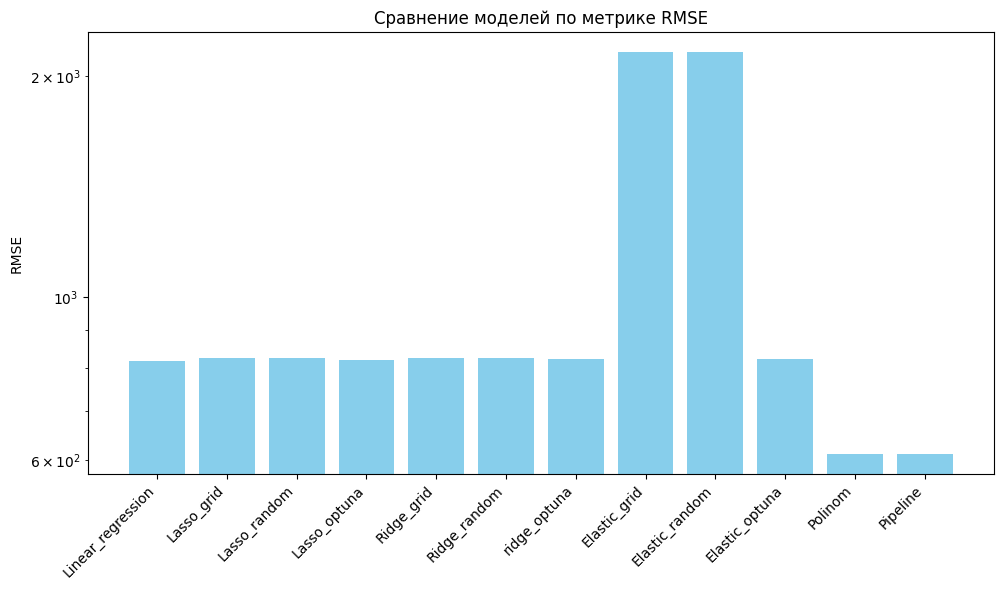

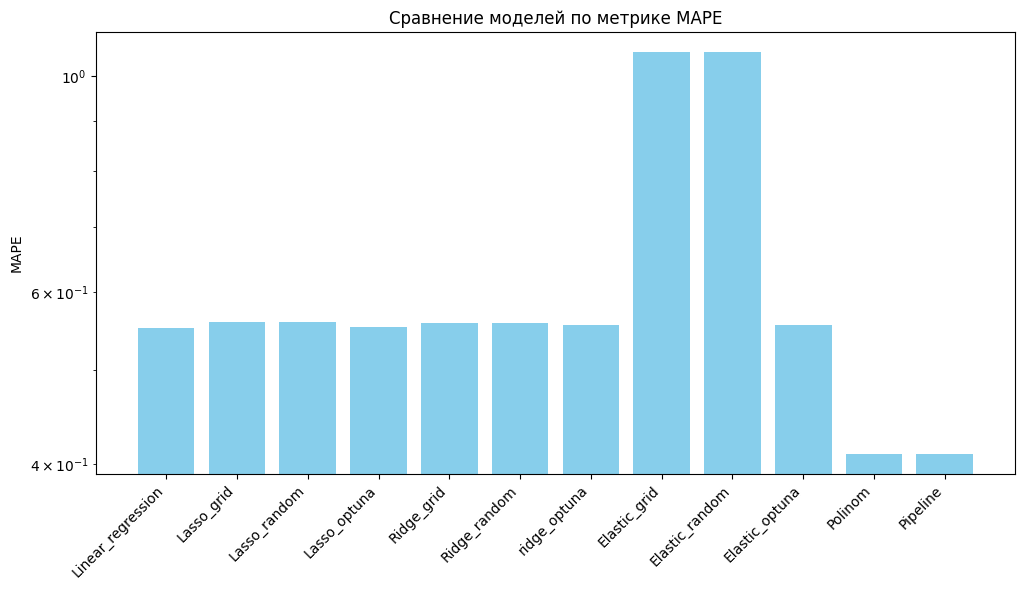

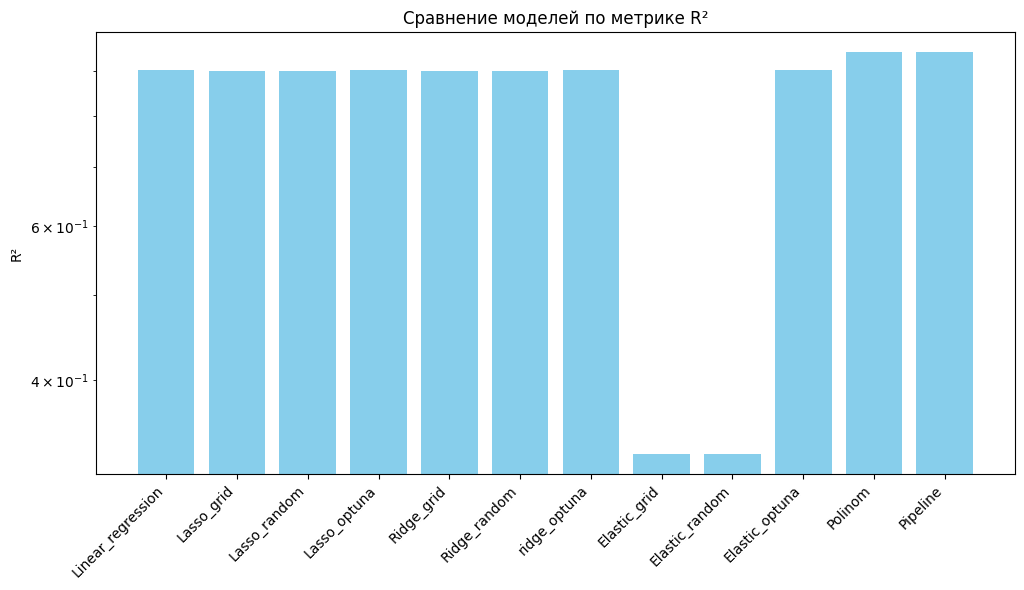

In [ ]:
models = table_all_metrics['Model'].tolist()
mae = table_all_metrics['MAE'].tolist()
mse = table_all_metrics['MSE'].tolist()
rmse = table_all_metrics['RMSE'].tolist()
mape = table_all_metrics['MAPE'].tolist()
r2 = table_all_metrics['R^2'].tolist()

# Построение графиков
metrics = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R²": r2}

for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.bar(models, metric_values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Сравнение моделей по метрике {metric_name}")
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.yscale('log')
    plt.show()

# Вывод: Лучшая модель регрессии

После анализа метрик всех моделей регрессии лучшей моделью является **Polinom** (или эквивалентная ей Pipeline, так как их метрики идентичны). 

## Обоснование выбора:
1. **Минимальные ошибки**:
   - **MAE**: 443.993762 — самое низкое значение среди всех моделей.
   - **MSE**: 438197.795584 — также минимальное значение.
   - **RMSE**: 661.965101 — лучшее значение.
   - **MAPE**: 0.446734 — наименьший процент ошибки.
   Эти метрики показывают, что Polinom делает наименьшие ошибки в предсказаниях.

2. **Максимальный R²**:
   - **R²**: 0.936675 — самый высокий показатель. Это говорит о том, что Polinom лучше всего объясняет вариацию целевой переменной.

3. **Сравнение с другими моделями**:
   - Модели Linear_regression, Lasso (все варианты), Ridge (все варианты) и Elastic_optuna показывают близкие результаты с R² около 0.9300–0.93007, но их ошибки выше, чем у Polinom.
   - Elastic_grid и Elastic_random имеют худшие показатели (например, R² = 0.902982), что делает их наименее предпочтительными.
   - Pipeline имеет идентичные метрики с Polinom, что может указывать на то, что это одна и та же модель или её вариация.

## Итог:
**Polinom** (или Pipeline) является лучшей моделью, так как она демонстрирует наименьшие ошибки по всем метрикам (MAE, MSE, RMSE, MAPE) и наивысший R², что свидетельствует о её превосходной предсказательной способности. Если требуется дальнейшая оптимизация, можно рассмотреть добавление новых признаков или настройку гиперпараметров, но текущие результаты уже впечатляющие.